In [1]:
import os, sys
os.chdir("..")
sys.path.append(".")  
os.getcwd()

'/Users/sbhandari/Documents/GitHub/epsilon-transformers'

In [2]:
from epsilon_transformers.persistence import LocalPersister, S3Persister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.training.configs.training_configs import TrainConfig
from pathlib import Path
persister = LocalPersister(collection_location=Path("models/mess3"))

/opt/anaconda3/envs/epstrans311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/anaconda3/envs/epstrans311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because a

In [3]:
import os
print("Current working directory:", os.getcwd())
print("Contents:", os.listdir())

from pathlib import Path
print("Resolved path:", Path("models/mess3").resolve())

Current working directory: /Users/sbhandari/Documents/GitHub/epsilon-transformers
Contents: ['.DS_Store', 'epsilon_transformers', 'experiments', 'pyproject.toml', 'epsilon_transformers.egg-info', 'tests', 'models', 'README.md', '.gitignore', 'examples', 'scripts', '.git']
Resolved path: /Users/sbhandari/Documents/GitHub/epsilon-transformers/models/mess3


In [5]:
model = RawModelConfig(
        d_vocab=3,
        d_model=64,
        n_ctx=10,
        d_head=8,
        n_head=1,
        d_mlp=256,
        n_layers=4,
    ).to_hooked_transformer(seed=1337, device='cpu')

persister.load_model(model,'629209600.pt')

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [ ]:
import torch
import numpy as np
from typing import Tuple, Optional, List


def compute_mixed_states_from_sequence(
    process,
    sequence: np.ndarray,
    initial_state_dist: Optional[np.ndarray] = None
) -> List[np.ndarray]:
    """
    Compute the mixed state (belief state) evolution for a given sequence.
    
    A mixed state eta is a probability distribution over the hidden states.
    Given observations, we compute the posterior distribution over states using
    the forward algorithm / belief propagation.
    
    This matches the reference implementation's evolve() method:
        eta_next = (eta @ T^token) / (eta @ T^token @ ones)
    
    Args:
        process: Process object with transition_matrix
        sequence: Array of observed tokens
        initial_state_dist: Initial belief state. If None, uses uniform distribution.
    
    Returns:
        List of mixed states (eta vectors), one for each position in sequence
        Length = len(sequence) + 1 (includes initial state)
        
    """
    n_states = process.num_states
    vocab_len = process.vocab_len
    T = process.transition_matrix  # Shape: [vocab_len, n_states, n_states]
    
    if initial_state_dist is None:
        eta = np.ones(n_states) / n_states
    else:
        eta = initial_state_dist.copy()
        eta = eta / eta.sum()  # Normalize
    
    mixed_states = [eta.copy()]
    

    for token in sequence:
        
        eta_next_unnorm = eta @ T[token]  # Shape: (n_states,)
        

        total = eta_next_unnorm.sum()
        if total > 1e-10:
            eta_next = eta_next_unnorm / total
        
        mixed_states.append(eta_next.copy())
        eta = eta_next
    
    return mixed_states


def token_probabilities_from_mixed_state(
    process,
    eta: np.ndarray
) -> np.ndarray:
    """
    Compute the probability distribution over next tokens given a mixed state.
    
    This matches the reference implementation's token_probabilities() method:
        p_i_unnorm = eta @ T^i @ ones
        p = p_i_unnorm / p_i_unnorm.sum()
    
    For a mixed state eta (distribution over hidden states), the probability of
    emitting token i is the sum of probabilities of all transitions that emit i:
        P(token=i | eta) = sum_s sum_s' eta[s] * T^i[s, s']
    
    Args:
        process: Process object with transition_matrix
        eta: Mixed state (probability distribution over states), shape (n_states,)
    
    Returns:
        Probability distribution over tokens, shape (vocab_len,)
    """
    T = process.transition_matrix  # Shape: [vocab_len, n_states, n_states]
    vocab_len = process.vocab_len
    
    token_probs = np.zeros(vocab_len)
    ones = np.ones(process.num_states)
    
    for token_idx in range(vocab_len):

        prob = eta @ T[token_idx] @ ones
        token_probs[token_idx] = prob
    
    total = token_probs.sum()
    if total > 1e-10:
        token_probs = token_probs / total
    
    return token_probs


def markov_kl_proc(
    model,
    process,
    sequences,
    pos_start: int = 0,
    process_id: int = 0,
    device: Optional[str] = None,
    max_seq_len: Optional[int] = 10
) -> Tuple[float, float]:
    """
    Compute KL divergence between actual Markov process states and model predictions.
    This uses the true Markov mixed state probabilities computed from the process.
    
    CORRECTED: This version properly computes belief states (mixed states) from
    observed sequences, matching the reference implementation's approach.
    
    The algorithm:
    1. For each sequence, compute the mixed states (eta vectors) using forward algorithm
    2. For each position, compute token probabilities from the mixed state at that position
    3. Compare these true probabilities with the model's predicted probabilities
    4. Compute bidirectional KL divergence
    
    Args:
        model: The transformer model (should output logits when called with input)
        process: Process object (from epsilon_transformers.process.Process) 
                 containing the transition matrix
        sequences: Tensor or numpy array of shape (n_gen, gen_len) containing generated sequences
        pos_start: Starting position for KL computation (default: 0)
                   Useful if you want to ignore initial positions
        process_id: ID for labeling different processes (for logging/tracking purposes)
        device: Device to run computations on ('cuda', 'cpu', etc.)
                If None, automatically selects cuda if available
        max_seq_len: Maximum sequence length the model can handle. If None, will try to infer
                     from model config. If sequences are longer, they will be truncated.
    
    Returns:
        Tuple of (markov_to_model_kl, model_to_markov_kl)
        - markov_to_model_kl: KL(true_markov || model_predictions)
          Measures how much information is lost when using model to approximate true distribution
        - model_to_markov_kl: KL(model_predictions || true_markov)
          Reverse KL divergence
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    if max_seq_len is None:
        max_seq_len=10
    
    if isinstance(sequences, np.ndarray):
        sequences_np = sequences
        x = torch.tensor(sequences, dtype=torch.long, device=device)
    else:
        sequences_np = sequences.cpu().numpy() if sequences.is_cuda else sequences.numpy()
        x = sequences.to(device)
    
    if x.shape[1] > max_seq_len:
        print(f"Warning: Truncating sequences from {x.shape[1]} to {max_seq_len} tokens")
        x = x[:, :max_seq_len]
        sequences_np = sequences_np[:, :max_seq_len]
    
    dist1 = []
    
    for seq in sequences_np:
        mixed_states = compute_mixed_states_from_sequence(process, seq)
        sequence_probs = []
        for i in range(pos_start, len(seq)):
            eta = mixed_states[i]
            token_probs = token_probabilities_from_mixed_state(process, eta)
            sequence_probs.append(token_probs)
        dist1.append(sequence_probs)

    dist1 = torch.tensor(np.array(dist1), dtype=torch.float32, device=device)
    
    with torch.no_grad():
        model_output = model(x)
        dist2 = model_output.softmax(dim=-1)
        
        if pos_start > 0:
            dist2 = dist2[:, pos_start-1:-1, :]
        else:
            dist2 = dist2[:, :-1, :]
    
    min_len = min(dist1.shape[1], dist2.shape[1])
    dist1 = dist1[:, :min_len, :]
    dist2 = dist2[:, :min_len, :]
    
    eps = 1e-8
    dist1_clamped = dist1.clamp(min=eps)
    dist2_clamped = dist2.clamp(min=eps)
    
    def kl_divergence(p, q):
        """Compute KL(P||Q)"""
        kl_div = p * (p.log() - q.log())
        # print(kl_div.shape)
        kl_div_last=kl_div[:,-1,:]
        # print(kl_div_last.shape)
        kl_sum = kl_div_last.sum(dim=-1)
        return kl_sum.mean().item()
    
    markov_to_model = kl_divergence(dist1_clamped, dist2_clamped)
    model_to_markov = kl_divergence(dist2_clamped, dist1_clamped)
    
    return markov_to_model, model_to_markov


def generate_sequences(
    process, 
    n_gen: int, 
    gen_len: int,
    initial_state_idx: Optional[int] = None
) -> np.ndarray:
    """
    Helper function to generate sequences from a process.
    
    This is simplified - we only need sequences, not the underlying pure states,
    since we'll compute mixed states (belief states) from sequences.
    
    Args:
        process: Process object from epsilon_transformers.process.Process
        n_gen: Number of sequences to generate
        gen_len: Length of each sequence
        initial_state_idx: Optional initial state index. If None, samples from steady state
    
    Returns:
        sequences: numpy array of shape (n_gen, gen_len) with token IDs
    """
    sequences = []
    
    for _ in range(n_gen):
        history = process.generate_process_history(
            total_length=gen_len,
            current_state_idx=initial_state_idx
        )
        sequences.append(history.symbols)
    
    return np.array(sequences)

def generate parallel_seq(process,n_gen, gen_len):
    T_list = process.transition_matrix
    

In [58]:
from epsilon_transformers.process.processes import Mess3
process = Mess3(x=0.4,a=0.8)
persister.load_model(model,'629209600.pt')
sequences = generate_sequences(
        process=process,
        n_gen=100,
        gen_len=10
    )
kl_m2m, kl_m2t = markov_kl_proc(
        model=model,
        process=process,
        sequences=sequences,
        device='cpu'
    )
    
print(f"{kl_m2m:.6f}")
#persister.load_model(model,'3187200.pt')

persister.load_model(model,'3187200.pt')
sequences = generate_sequences(
        process=process,
        n_gen=10000,
        gen_len=10
    )
kl_m2m, kl_m2t = markov_kl_proc(
        model=model,
        process=process,
        sequences=sequences,
        device='cpu'
    )
    
print(f"{kl_m2m:.6f}")
persister.load_model(model,'915200.pt')
# persister.load_model(model,'640000.pt')
sequences = generate_sequences(
        process=process,
        n_gen=10000,
        gen_len=10
    )
kl_m2m, kl_m2t = markov_kl_proc(
        model=model,
        process=process,
        sequences=sequences,
        device='cpu'
    )
    
print(f"{kl_m2m:.6f}")
persister.load_model(model,'640000.pt')
sequences = generate_sequences(
        process=process,
        n_gen=10000,
        gen_len=10
    )
kl_m2m, kl_m2t = markov_kl_proc(
        model=model,
        process=process,
        sequences=sequences,
        device='cpu'
    )
    
print(f"{kl_m2m:.6f}")
persister.load_model(model,'64000.pt')
sequences = generate_sequences(
        process=process,
        n_gen=10000,
        gen_len=10
    )
kl_m2m, kl_m2t = markov_kl_proc(
        model=model,
        process=process,
        sequences=sequences,
        device='cpu'
    )
    
print(f"{kl_m2m:.6f}")
persister.load_model(model,'6400.pt')
sequences = generate_sequences(
        process=process,
        n_gen=10000,
        gen_len=10
    )
kl_m2m, kl_m2t = markov_kl_proc(
        model=model,
        process=process,
        sequences=sequences,
        device='cpu'
    )
    
print(f"{kl_m2m:.6f}")

0.243385
0.244217
0.209084
0.218803
0.173752
0.113537


In [47]:
def process_kl_divergence(
    process_1,
    process_2,
    n_samples: int = 10000,
    seq_len: int = 100,
    initial_state_dist: Optional[np.ndarray] = None,
    device: str = "cpu"
) -> Tuple[float, float]:
    """
    Compute KL divergence between two Markov processes.
    
    Algorithm:
    1. Generate sequences from process_1
    2. For each sequence, compute mixed states and token probabilities for BOTH processes
    3. Compute KL divergence between the probability distributions
    
    Args:
        process_1: First Markov process (e.g., Mess3(x=0.1, a=0.5))
        process_2: Second Markov process (e.g., Mess3(x=0.2, a=0.6))
        n_samples: Number of sequences for Monte Carlo estimation
        seq_len: Length of each sequence
        initial_state_dist: Initial belief state
        device: Device for computation
    
    Returns:
        (kl_p1_to_p2, kl_p2_to_p1)
        - kl_p1_to_p2: KL(process_1 || process_2)
        - kl_p2_to_p1: KL(process_2 || process_1)
    
    Example:
        >>> from epsilon_transformers.process.processes import Mess3
        >>> process_1 = Mess3(x=0.1, a=0.5)
        >>> process_2 = Mess3(x=0.2, a=0.6)
        >>> kl_12, kl_21 = process_kl_divergence(process_1, process_2)
        >>> print(f"KL(P1||P2): {kl_12:.6f}")
        >>> print(f"KL(P2||P1): {kl_21:.6f}")
    """
    # Generate sequences from process_1
    sequences = generate_sequences(process_1, n_gen=n_samples, gen_len=seq_len)
    
    dist1_list = []
    dist2_list = []
    
    for seq in sequences:
        # Compute mixed states for both processes
        mixed_states_1 = compute_mixed_states_from_sequence(
            process_1, seq, initial_state_dist
        )
        mixed_states_2 = compute_mixed_states_from_sequence(
            process_2, seq, initial_state_dist
        )
        
        seq_probs_1 = []
        seq_probs_2 = []
        
        for i in range(len(seq)):
            # Process 1 probabilities
            eta1 = mixed_states_1[i]
            probs1 = token_probabilities_from_mixed_state(process_1, eta1)
            seq_probs_1.append(probs1)
            
            # Process 2 probabilities
            eta2 = mixed_states_2[i]
            probs2 = token_probabilities_from_mixed_state(process_2, eta2)
            seq_probs_2.append(probs2)
        
        dist1_list.append(seq_probs_1)
        dist2_list.append(seq_probs_2)
    
    # Convert to tensors
    dist1 = torch.tensor(np.array(dist1_list), dtype=torch.float32, device=device)
    dist2 = torch.tensor(np.array(dist2_list), dtype=torch.float32, device=device)
    
    eps = 1e-8
    dist1_clamped = dist1.clamp(min=eps)
    dist2_clamped = dist2.clamp(min=eps)
    
    def kl_divergence(p, q):
        kl_div = p * (p.log() - q.log())
        kl_last=kl_div[:,-1,:]
        kl_sum = kl_div.sum(dim=-1)
        return kl_sum.mean().item()
    
    kl_p1_to_p2 = kl_divergence(dist1_clamped, dist2_clamped)
    kl_p2_to_p1 = kl_divergence(dist2_clamped, dist1_clamped)
    
    return kl_p1_to_p2, kl_p2_to_p1


In [59]:
process_1=Mess3(x=0.15,a=0.6)
process_2=Mess3(x=0.4,a=0.8)
kl1,kl2=process_kl_divergence(
    process_1,
    process_2,
    n_samples= 10000,
    seq_len=10,
    initial_state_dist= None,
    device= "cpu"
)
print(f"{kl1:.6f}")

0.032705


/var/folders/66/w340bvhn7375dh8qw5cmscyc0000gn/T/ipykernel_66958/2101063562.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


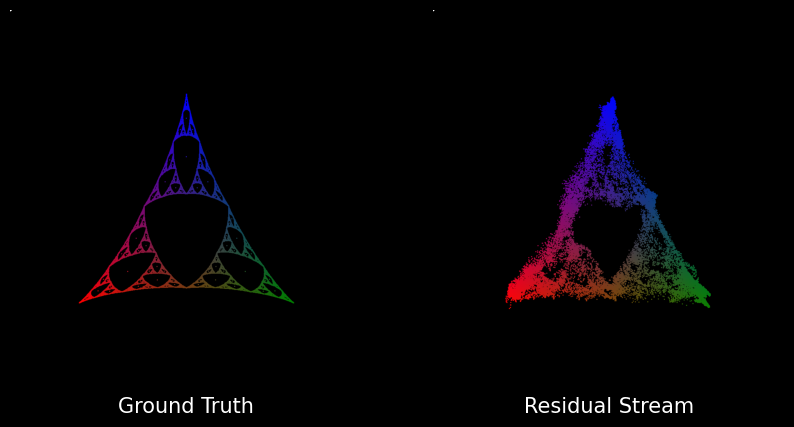

In [6]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.visualization.plots import plot_ground_truth_and_evaluated_2d_simplex


process = Mess3()


belief_states_reshaped, predicted_beliefs = find_msp_subspace_in_residual_stream(model=model, process=process, num_sequences=10000)
fig = plot_ground_truth_and_evaluated_2d_simplex(ground_truth_tensor=belief_states_reshaped, predicted_beliefs=predicted_beliefs, plot_triangles=True, facecolor='black', px=1)

fig.show()

In [78]:
T_list = list[process.transition_matrix]
print(T_list)
print(type(T_list))
n_states=3
d_vocab=3
data=ParallelMarkovGeneratorGPU(n_states,n_gen=4096, gen_len=10,d_vocab=3,T_list=T_list, device='cuda')

list[array([[[0.16, 0.04, 0.04],
        [0.32, 0.02, 0.04],
        [0.32, 0.04, 0.02]],

       [[0.02, 0.32, 0.04],
        [0.04, 0.16, 0.04],
        [0.04, 0.32, 0.02]],

       [[0.02, 0.04, 0.32],
        [0.04, 0.02, 0.32],
        [0.04, 0.04, 0.16]]])]
<class 'types.GenericAlias'>
CUDA not available, falling back to CPU. Performance will be slower.


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [71]:
class ParallelMarkovGeneratorGPU:
    """
    Generates Markov sequences in a fully parallelized batch on a GPU.
    """
    def __init__(self, n_states: int,n_gen:int, gen_len:int, d_vocab: int, T_list: list[np.ndarray], 
                 eta0: Optional[np.ndarray] = None, device: str = 'cuda', seed:int=42 ):
        
        if not torch.cuda.is_available() and device == 'cuda':
            print("CUDA not available, falling back to CPU. Performance will be slower.")
            device = 'cpu'
        self.device = torch.device(device)
        self.n_gen=n_gen
        self.gen_len=gen_len
        self.seed=seed
        self.n_states = n_states
        self.d_vocab = d_vocab
        
        # Stack T_list into a single tensor of shape (V, n, n) and move to GPU
        self.T_stack = torch.tensor(np.array(T_list), dtype=torch.float32).to(self.device)

        # Prepare initial state eta0
        if eta0 is None:
            eta0 = np.full((self.n_states,), 1.0 / self.n_states)
        self.eta0 = torch.tensor(eta0, dtype=torch.float32).to(self.device)
        
        self.data=[]
        self.states=[]
        self.generate_batch()
    def generate_batch(self):
        """
        Generates a batch of n_gen sequences, each of length gen_len.
        
        Returns:
            torch.Tensor: A tensor of token indices with shape (n_gen, gen_len).
        """
        # Initialize the states for the entire batch
        # Shape: (n_gen, n_states)
        n_gen, gen_len = self.n_gen, self.gen_len
        eta_batch = self.eta0.expand(n_gen, -1)
        g = torch.Generator(device=self.device)
        g.manual_seed(self.seed)

        # List to store the generated tokens for each step
        generated_tokens = []
        generated_probs = []
        generated_states=[]
        generated_states.append(eta_batch.cpu())

        for _ in range(gen_len):
            # --- 1. Calculate token probabilities for the entire batch ---
            # We use einsum for a clear and efficient batched matrix multiplication.
            # 'bi,vij->bvj' means: for each item 'b' in the batch and each vocab item 'v',
            # multiply state (bi) with matrix (vij) to get the next unnormalized state (bvj).
            # eta_batch shape:      (n_gen, n_states)
            # self.T_stack shape: (d_vocab, n_states, n_states)
            unnorm_next_eta_batch = torch.einsum('bi,vij->bvj', eta_batch, self.T_stack)
            
            # Sum over the last dimension (j) to get token probabilities
            # Shape: (n_gen, d_vocab)
            p_batch = unnorm_next_eta_batch.sum(dim=-1)
            #p_batch=p_batch/(p_batch.sum(dim=-1,keepdim=True)) # Normalize to get probabilities, add epsilon for stability
            
            # --- 2. Sample the next token for the entire batch ---
            # torch.multinomial samples from the distributions in p_batch
            # Shape: (n_gen, 1)
            next_token_batch = torch.multinomial(p_batch, num_samples=1,generator=g)
            generated_tokens.append(next_token_batch.cpu())
            generated_probs.append(p_batch.view(n_gen, 1, self.d_vocab).cpu())
            
            # --- 3. Evolve the state for the entire batch ---
            # Get the specific unnormalized next state that corresponds to the chosen token
            # This is a highly efficient way to select the right T^k for each item in the batch
            # Shape: (n_gen, n_states)
            next_eta_numer = torch.gather(
                unnorm_next_eta_batch, 
                1, 
                next_token_batch.unsqueeze(-1).expand(-1, -1, self.n_states)
            ).squeeze(1)

            # Normalize to get the next state distribution
            next_eta_denom = next_eta_numer.sum(dim=-1, keepdim=True)
            eta_batch = next_eta_numer / (next_eta_denom) # Add epsilon for stability
            del next_eta_denom, next_eta_numer, p_batch, next_token_batch, unnorm_next_eta_batch
            generated_states.append(eta_batch.cpu())

        token_tensor=torch.stack(generated_tokens).squeeze(-1).T 
        state_tensor=torch.stack(generated_states).permute(1,0,2)  

        self.data = [token_tensor[i].to(self.device) for i in range(self.n_gen)]
        self.states = [
        [arr for arr in seq.cpu().numpy().astype(float)]
        for seq in state_tensor]
    def __len__(self):
            return len(self.data)

    def __getitem__(self, idx):
            return {"tokens": self.data[idx]}

    def to(self, device):
            if str(device) != str(self.device):
                self.data = [tensor.to(device) for tensor in self.data]
                self.device = torch.device(device)
            return self

    def get_stacked_data(self):
            return torch.stack(self.data)
